<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #7: Clasificación y Agrupación
`Fecha de entrega: Octubre 24, 2020. (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`

In [1]:
import re
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [2]:
# Cargar datos
path = 'D:/01. PC LENOVO/02. ESPECIALIZACION/Semestre 2/2. NLP/09 Clase/reviews_vidjew_es.csv'
data = pd.read_csv(path)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games


# Parte 1: Clasificación

### `[6 pts]` Punto 1: Dividir el conjunto de datos en entrenamiento y prueba

In [3]:

train, test = train_test_split(data, test_size=0.2, random_state=42)

print(f"El cojunto de datos de entrenamiento tiene {train.shape[0]} registros")
print(f"El cojunto de datos de prueba tiene {test.shape[0]} registros")

El cojunto de datos de entrenamiento tiene 800 registros
El cojunto de datos de prueba tiene 200 registros


###  `[6 pts]` Punto 2: Hacer pre-procesamiento del texto

In [4]:
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)

In [7]:
X_train = tfidf_vect.fit_transform(train.review_body.values)
y_train = train.product_category.values

X_test = tfidf_vect.transform(test.review_body.values)
y_test = test.product_category.values

###  `[6 pts]` Punto 3: Entrenar el modelo
Puedes escoger el que quieras: Regresión Logística, Naive-Bayes, SVM, u otro.

In [8]:
# Inicializamos los clasificadores
logreg = LogisticRegression(class_weight="balanced")

In [9]:
# Entrenamos los modelos
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

###  `[6 pts]` Punto 4: Métricas de evaluación
Exactitud, precisión y sensibilidad

In [12]:
# Hacemos las predicciones para los datos de prueba (test)
y_pred_logreg = logreg.predict(X_test)

In [19]:
print(f"Exactitud: {accuracy_score(y_test, y_pred_logreg):>7.2f}")
print(f"Precisión: {precision_score(y_test, y_pred_logreg, pos_label='jewelry'):>7.2f}")
print(f"Sensibilidad: {recall_score(y_test, y_pred_logreg, pos_label='jewelry'):>7.2f}")



Exactitud:    0.86
Precisión:    0.86
Sensibilidad:    0.86


###  `[BONUS: 3 pts]` Matriz de confusión

Text(0.5, 1.0, 'Regresión Logística')

<Figure size 1080x1080 with 0 Axes>

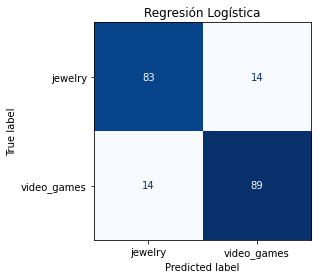

In [24]:
fig = plt.figure(figsize=(15,15))
plot_confusion_matrix(logreg, X_test, y_test, cmap = 'Blues').im_.colorbar.remove()
plt.title("Regresión Logística")

###  `[BONUS: 1 pts]` Términos más importantes de cada categoría

In [26]:
vocab = {value:key for key, value in tfidf_vect.vocabulary_.items()}

In [36]:
#Terminos mas importantes para la categoria jewelry
[(vocab[e[0]],round(e[1],2)) for e in zip(logreg.coef_[0].argsort(),sorted(logreg.coef_[0]))][:10]

[('calidad', -1.96),
 ('foto', -1.94),
 ('pulsera', -1.87),
 ('bonito', -1.85),
 ('bonitos', -1.84),
 ('bonita', -1.55),
 ('plata', -1.53),
 ('cadena', -1.43),
 ('pequeño', -1.2),
 ('cierre', -1.16)]

In [30]:
#Terminos mas importantes para la categoria video_games
[(vocab[e[0]],round(e[1],2)) for e in zip(logreg.coef_[0].argsort(),sorted(logreg.coef_[0]))][-10:]

[('cable', 0.99),
 ('botones', 1.01),
 ('consola', 1.13),
 ('hijo', 1.18),
 ('funciona', 1.2),
 ('ps', 1.26),
 ('jugar', 1.36),
 ('perfecto', 1.36),
 ('mando', 1.94),
 ('juego', 3.61)]

# Parte 2: Agrupación

###  `[6 pts]` Punto 1: Hacer pre-procesamiento del texto

In [38]:
def pre_procesado2(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    return texto


tfidf_vect2 = TfidfVectorizer(preprocessor=pre_procesado2)
tfidf = tfidf_vect2.fit_transform(data.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns=tfidf_vect2.get_feature_names())

###  `[6 pts]` Punto 2: Método del codo para determinar $K$

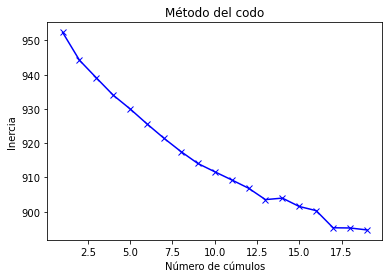

In [40]:
ks = []
kinertia = []

for k in range(1,20):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    ks.append(k)
    kinertia.append(kmeans.inertia_)
    
plt.xlabel("Número de cúmulos"); 
plt.ylabel("Inercia");
plt.title('Método del codo')
plt.plot(ks,kinertia, 'bx-');

###  `[6 pts]` Punto 3: Entrenar modelo con el $K$ escogido

In [58]:
k_pt = 5
model = KMeans(n_clusters=k_pt)
model.fit(tfidf_matrix)

KMeans(n_clusters=5)

In [61]:
data['cluster'] = model.labels_
#data['cluster']
#data['cluster'].value_counts()
data['cluster'].value_counts(normalize=True)

1    0.345
4    0.313
2    0.123
0    0.121
3    0.098
Name: cluster, dtype: float64

###  `[BONUS: 3 pts]` Visualización usando PCA

In [62]:
data['cluster'] = model.labels_
pca = PCA(n_components=2)

result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['cluster'] = data.cluster.values
result['texto'] = data.review_body

colorsIdx = {0: 'blue', 
             1: 'yellow',
             2: 'green',
             3: 'red',
             4: 'white', 
             5: 'black',
             6: 'brown',
             7: 'azure',
             8: 'ivory', 
             9: 'teal',
             10: 'silver',
             11: 'purple',
             12: 'chocolate'}


cols = data['cluster'].map(colorsIdx)

trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color=cols)) 

layout = go.Layout(title="PCA")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

# Parte 3: Comparación

### `[6 pts]` Punto 1: Hacer predicción para estas dos frases de los dos modelos

In [68]:
test = ["Necesitas el juego inicial para eso", "Preciosos estos aretes, buena calidad"]
# transformar con tfidf usado para clasificación
nuevo_trans_cla = tfidf_vect.transform(test)

# resultado para clasificación
logreg.predict(nuevo_trans_cla)

array(['video_games', 'jewelry'], dtype=object)

In [69]:
# transformar con tfidf usado para agrupación
nuevo_trans = tfidf_vect2.transform(test)
# resultado para agrupación
model.predict(nuevo_trans)

array([1, 3])

### `[2 pts]` Punto 2: Preguntas

- ¿A cuál modelo le fue mejor?   
Al modelo de clasificación 
- ¿Cuál modelo se demoró más en entrenar?  
El modelo de calsificación
- Según los resultados del $K$-Means, ¿cuál es la estructura latente de los datos?  
Los datos se dividen por le número de estrellas
- ¿Alguna otra observación?